# Dependencies

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
import matplotlib.pyplot as plt

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 30

plt.rc('font', size=SMALL_SIZE)          
plt.rc('axes', titlesize=SMALL_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE)    
plt.rc('xtick', labelsize=SMALL_SIZE)    
plt.rc('ytick', labelsize=SMALL_SIZE)    
plt.rc('legend', fontsize=SMALL_SIZE)    
plt.rc('figure', titlesize=BIGGER_SIZE, figsize=(15,8)) 

# IPF Demo

## Setup

First we'll generate some data, and for any data that is lower than some minimum threshold, we'll replace it with a random seed:

In [4]:
RANGE = (1, 1000)
MIN_VALUE = 10
SIZE = (100,100)

# Generate some original data
original_data = np.rint(np.random.uniform(low=RANGE[0], high=RANGE[1], size=SIZE))

# Any value less than MIN_VALUE is going to be suppressed.
missing_value_mask = original_data < MIN_VALUE
missing_values = original_data[missing_value_mask]

# Calculate the totals before we suppress.
column_totals = np.sum(original_data, axis=0)
row_totals = np.sum(original_data, axis=1)


# Replace the suppressed numbers with a random number in the interval [0, MIN_VALUE]
suppressed_data = np.copy(original_data)
suppressed_data[missing_value_mask] = np.rint(np.random.uniform(low=1, high=MIN_VALUE, size=missing_values.shape))

In [5]:
print(missing_values)
print(suppressed_data[missing_value_mask])

[ 7.  2.  8.  4.  9.  6.  5.  8.  4.  6.  3.  1.  2.  4.  8.  2.  7.  2.
  3.  7.  4.  3.  6.  6.  2.  5.  7.  3.  5.  8.  7.  5.  5.  2.  4.  2.
  1.  5.  8.  6.  5.  6.  2.  6.  4.  6.  6.  6.  7.  9.  7.  2.  3.  2.
  1.  4.  5.  3.  1.  6.  9.  6.  7.  6.  2.  5.  9.  9.  4.  5.  2.  5.
  6.  6.  3.  7.  9.  7.  3.  5.  5.  2.  5.  7.]
[  7.   4.   2.   4.   1.   9.   2.   6.   2.   4.   5.   3.   4.   3.   8.
   4.   9.   1.   4.   2.   1.   2.   2.   7.   2.   6.   3.   5.   6.   4.
   6.   8.   3.  10.  10.   5.   5.   5.   9.   6.   6.   5.  10.   9.   2.
   5.   7.   2.   4.   8.   5.   6.   4.   7.   7.   3.  10.   3.   5.   5.
   3.   2.   9.   3.   6.   5.   7.   6.   5.   9.   6.   8.   2.   6.   9.
   8.   8.   5.   7.   7.   4.   6.   8.   7.]


Let's take a look at how far off our random seeds are:

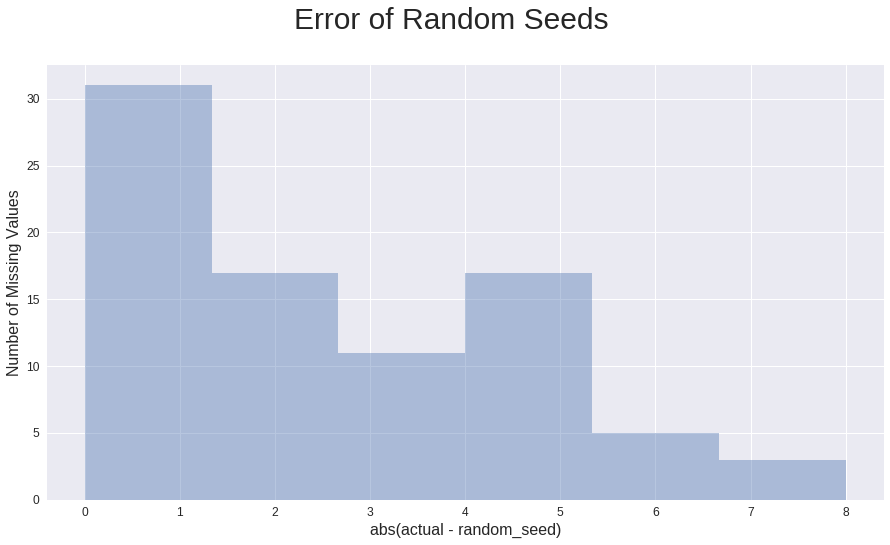

In [9]:
errors = np.absolute(suppressed_data[missing_value_mask] - missing_values)
sns.distplot(errors, kde=False)
plt.suptitle("Error of Random Seeds")
plt.ylabel("Number of Missing Values")
plt.xlabel("abs(actual - random_seed)")
plt.show()

In [7]:
stats.describe(errors)

DescribeResult(nobs=84, minmax=(0.0, 8.0), mean=2.5357142857142856, variance=3.8420826161790012, skewness=0.8780720757250956, kurtosis=0.3882195251671261)

## IPF

In [10]:
CONVERGENCE_THRESHOLD = 1e-3
MAX_ITERATIONS = 50000

delta = CONVERGENCE_THRESHOLD + 1
i = 0

while delta > CONVERGENCE_THRESHOLD and i < MAX_ITERATIONS:
    before = suppressed_data[missing_value_mask]
    
    current_row_totals = np.sum(suppressed_data, axis=1)
    for row in range(SIZE[0]):
        missing_indexes = missing_value_mask[row, :]    
        suppressed_data[row, missing_indexes] = suppressed_data[row, missing_indexes] / current_row_totals[row] 
        suppressed_data[row, missing_indexes] = suppressed_data[row, missing_indexes] * row_totals[row]
        
    current_column_totals = np.sum(suppressed_data, axis=0)
    for col in range(SIZE[1]):
        missing_indexes = missing_value_mask[:, col]    
        suppressed_data[missing_indexes, col] = suppressed_data[missing_indexes, col] / current_column_totals[col] 
        suppressed_data[missing_indexes, col] = suppressed_data[missing_indexes, col] * column_totals[col]    
    
    after = suppressed_data[missing_value_mask]
    delta = np.sum(np.abs(after-before))
    i += 1

How did we do?

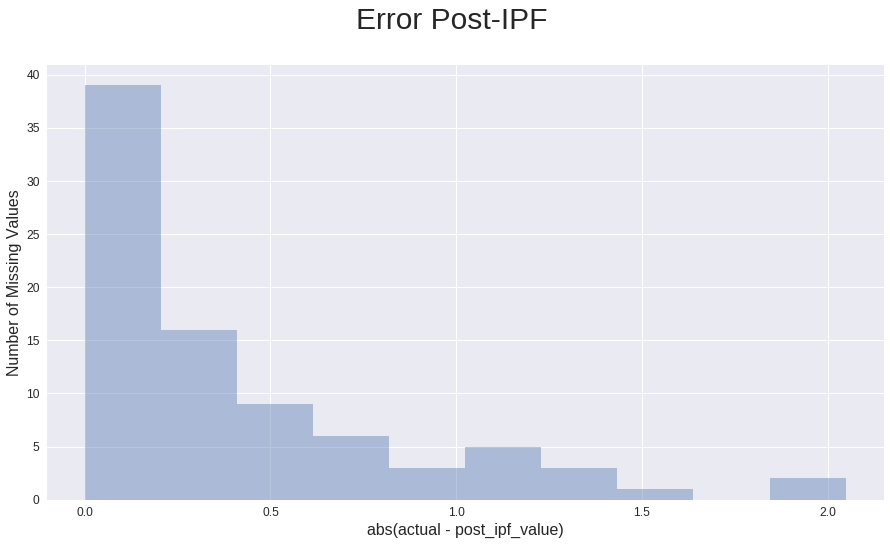

In [14]:
errors = np.absolute(suppressed_data[missing_value_mask] - missing_values)
sns.distplot(errors, kde=False)
plt.suptitle("Error Post-IPF")
plt.ylabel("Number of Missing Values")
plt.xlabel("abs(actual - post_ipf_value)")
plt.show()

In [12]:
print(stats.describe(errors))
print(i)

DescribeResult(nobs=84, minmax=(0.0, 2.0482400537029797), mean=0.40214191898690094, variance=0.21234535459954387, skewness=1.5609635911077497, kurtosis=2.048922754655198)
28597


In [ ]:
print(missing_values)
print(np.rint(suppressed_data[missing_value_mask]))